## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [212]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [213]:
# Random state seed
rseed = 42

## Load and explore data

In [214]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

In [215]:
# Check the shape
print(df.shape)

(167, 10)


In [216]:
# Check datatypes & counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [217]:
# Get descriptive statistics
print(df.describe())

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

In [218]:
# Identify any missing data
print(df.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [219]:
# Drop any non-numeric features (columns)
numeric_df = df.select_dtypes(include=['float64', 'int64'])


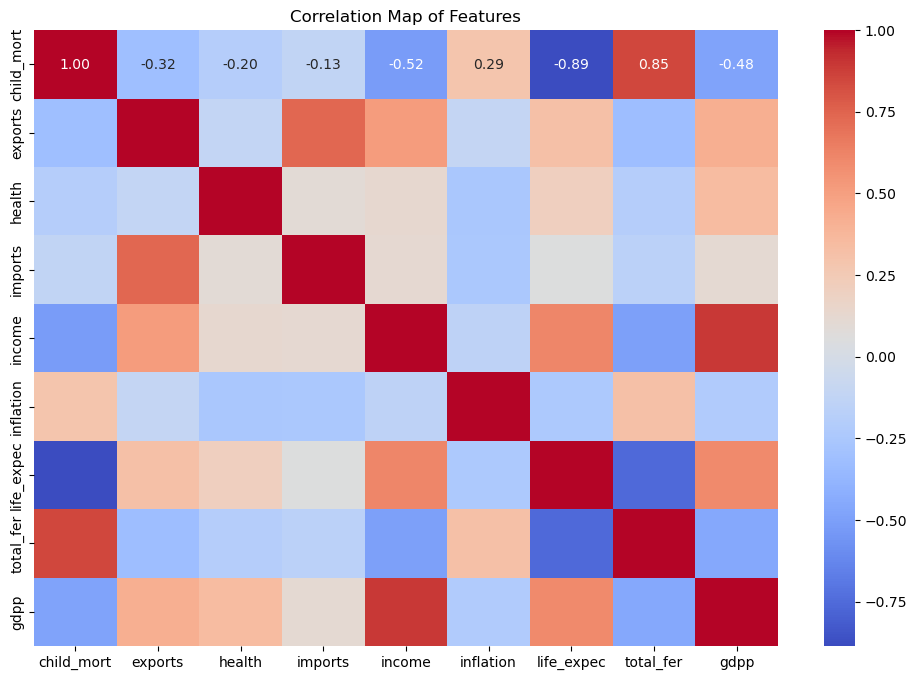

In [220]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Map of Features')
plt.show()

<Figure size 1200x800 with 0 Axes>

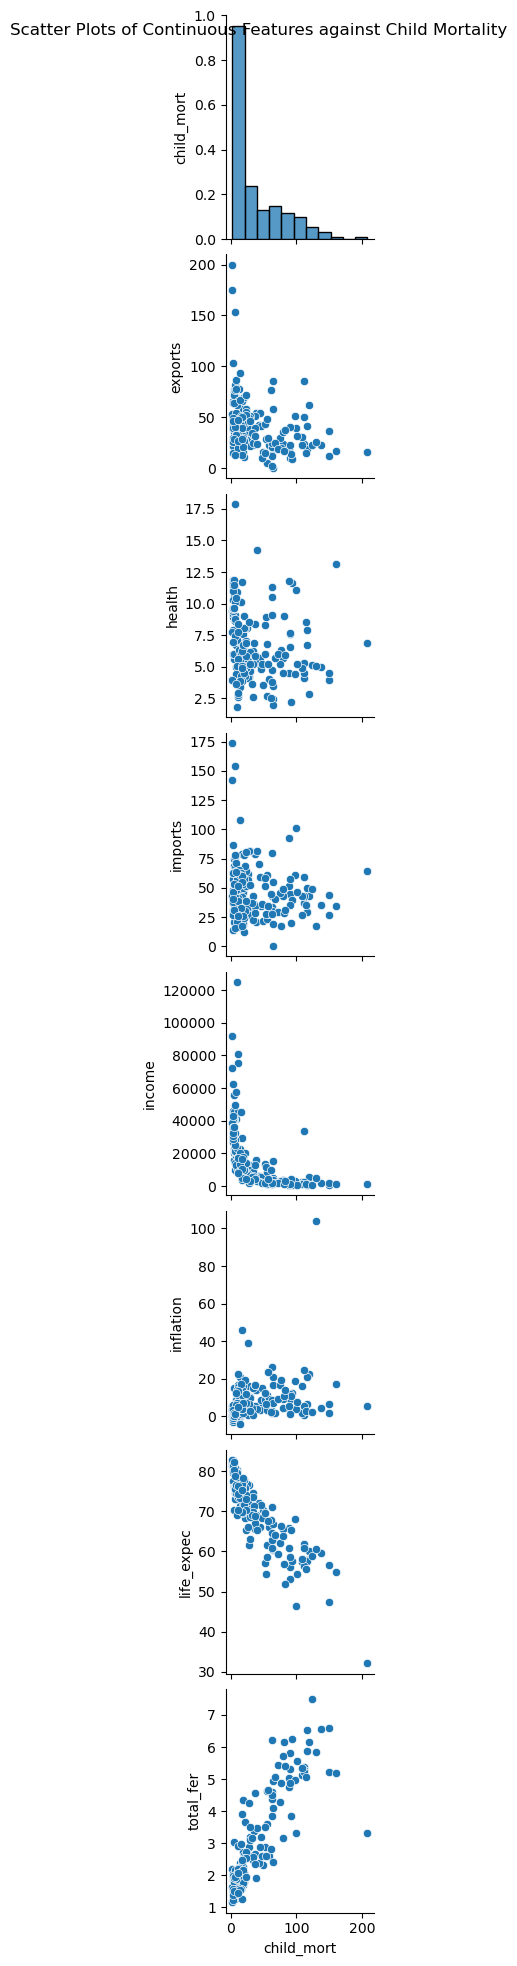

In [221]:
# Explore the continuous independent features against child_mort using scatter plots.
plt.figure(figsize=(12, 8))
sns.pairplot(numeric_df, x_vars=['child_mort'], y_vars=numeric_df.columns[:-1], kind='scatter')
plt.suptitle('Scatter Plots of Continuous Features against Child Mortality')
plt.show()

<Figure size 1200x800 with 0 Axes>

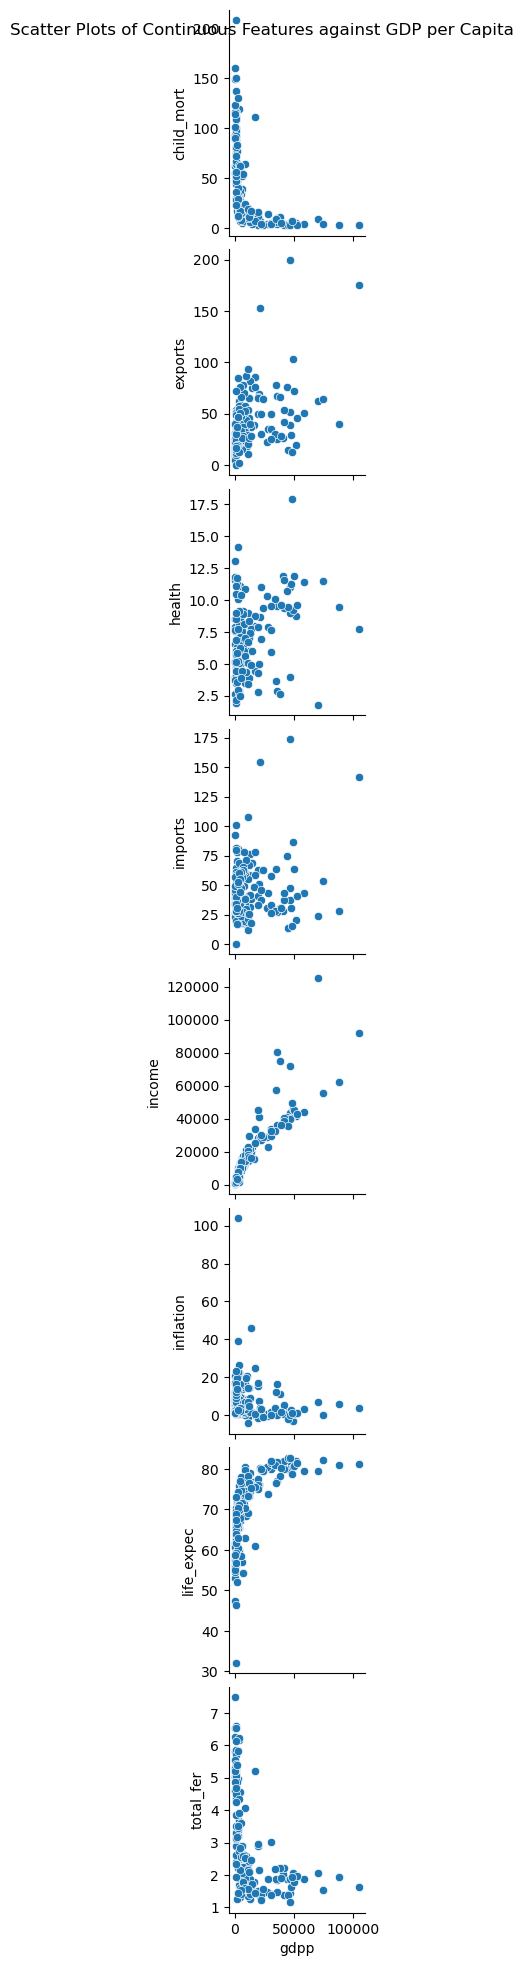

In [222]:
# Explore the continuous independent features against gdpp using scatter plots.
plt.figure(figsize=(12, 8))
sns.pairplot(numeric_df, x_vars=['gdpp'], y_vars=numeric_df.columns[:-1], kind='scatter')
plt.suptitle('Scatter Plots of Continuous Features against GDP per Capita')
plt.show()

<Figure size 1500x1000 with 0 Axes>

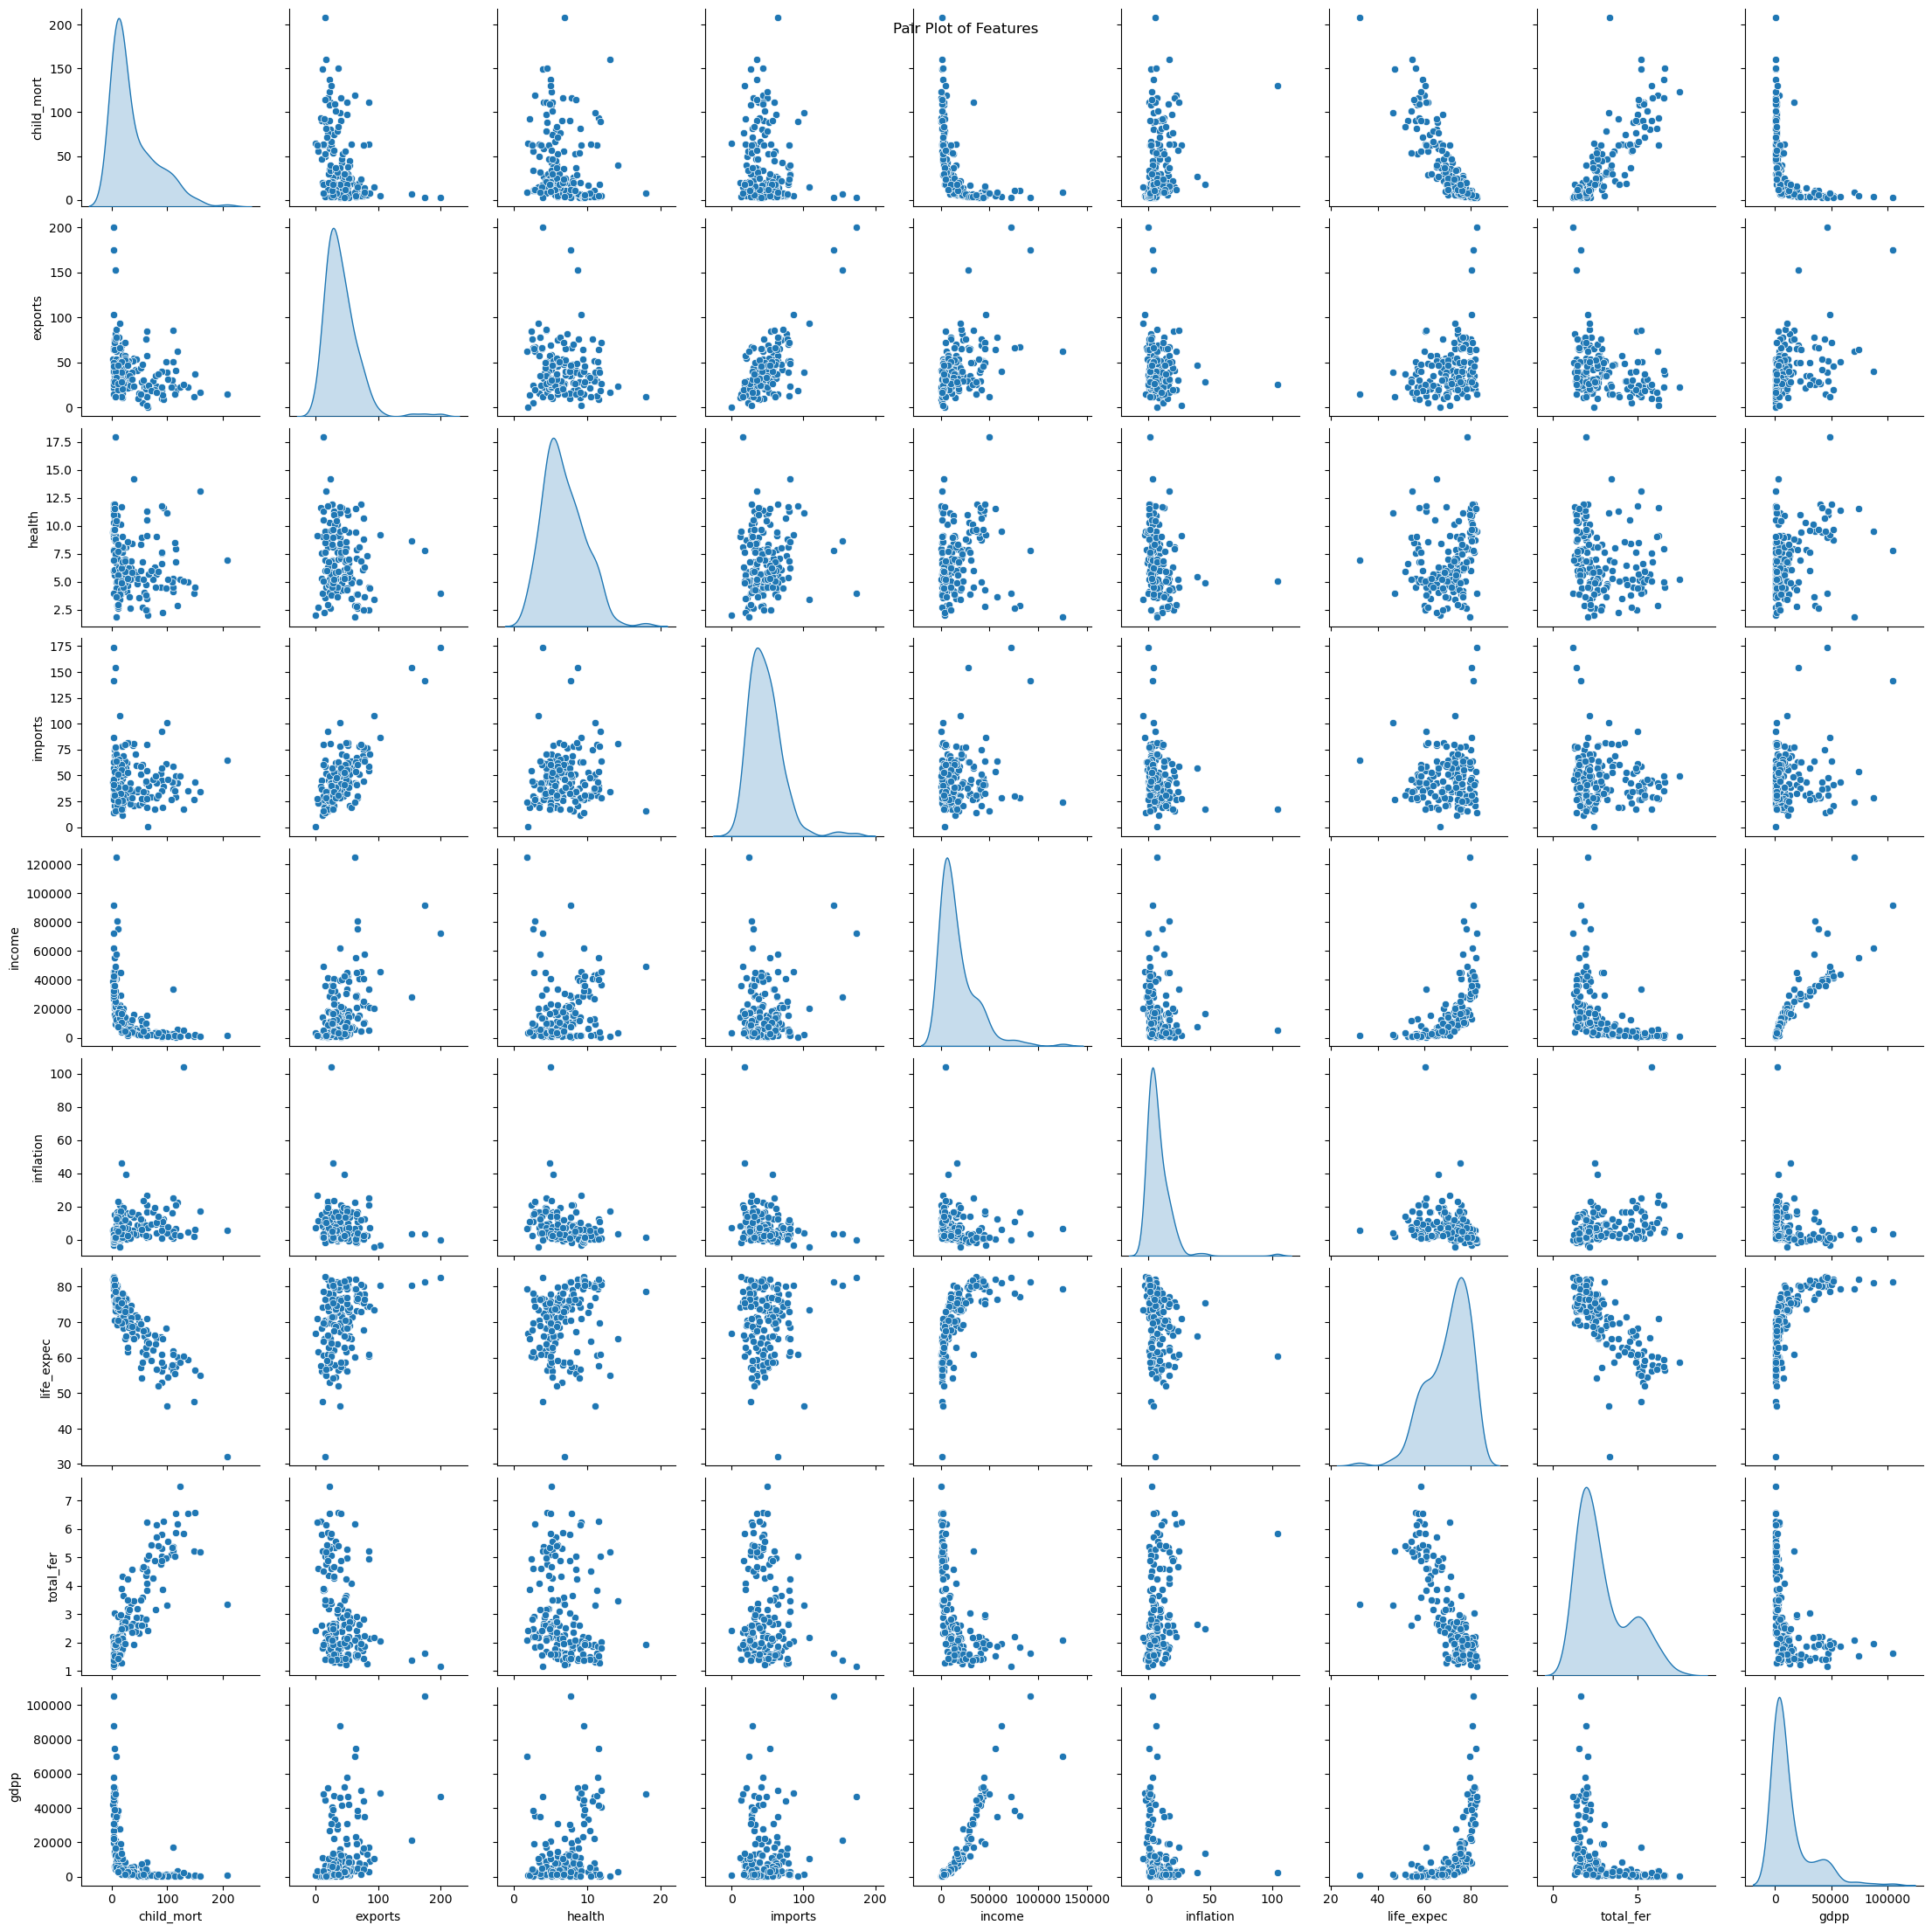

In [223]:
# Create a pair plot
# Hint: Explore seaborn pairplot
plt.figure(figsize=(15, 10))
sns.pairplot(numeric_df, diag_kind='kde')
plt.suptitle('Pair Plot of Features')
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [224]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

# Display the first few rows of the scaled dataframe
df_scaled.head()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

In [225]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset

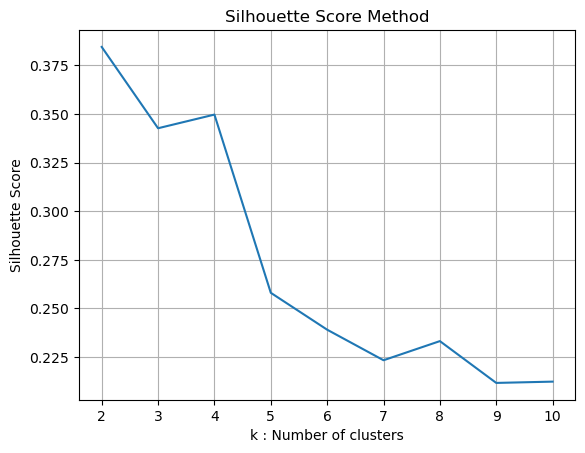

In [226]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.
7

## Fitting a K-Means Model with the selected K value

In [227]:
# Remember to set the random_state to rseed

# Fit KMeans model with K=7
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(df_scaled)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_


In [228]:
# Count the number of records in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_counts)


0    53
1    22
2    22
3     4
4    24
5    38
6     4
Name: count, dtype: int64


In [229]:
# Check model performance with the silhouette coefficient
from sklearn.preprocessing import StandardScaler

# Exclude non-numeric columns before calculating silhouette score
numeric_data = df.drop(columns=['country'])  

# Standardize the numeric data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numeric_data)

silhouette_avg = silhouette_score(data_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")



Silhouette Score: 0.18523284343501126


## Predictions

In [230]:
# Add the predicted cluster label column to the original dataframe

# Initialize KMeans model and fit on scaled data
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_scaled)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the original dataframe
df['Cluster_Labels'] = cluster_labels

# Display the updated dataframe with cluster labels
print(df.head())


               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  Cluster_Labels  
0       9.44        56.2       5.82    553               1  
1       4.49        76.3       1.65   4090               2  
2      16.10        76.5       2.89   4460               2  
3      22.40        60.1       6.16   3530               1  
4       1.44        76.8       2.13  12200               2  


## Visualisation of clusters

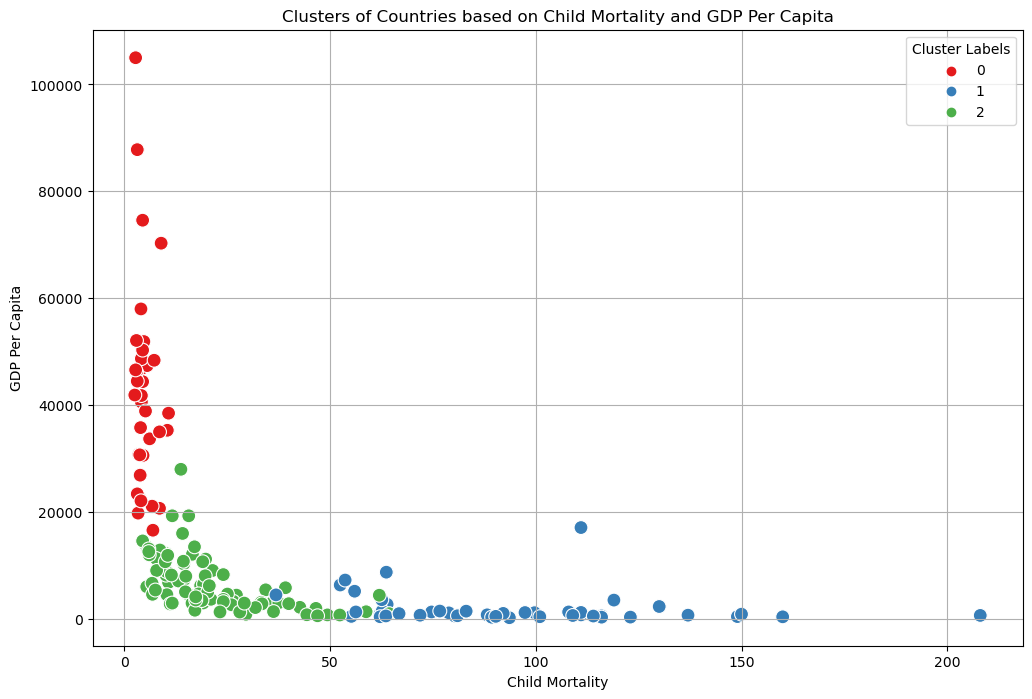

In [231]:
# Visualisation of clusters: child mortality vs gdpp

plt.figure(figsize=(12, 8))
sns.scatterplot(x='child_mort', y='gdpp', hue='Cluster_Labels', data=df, palette='Set1', s=100)
plt.title('Clusters of Countries based on Child Mortality and GDP Per Capita')
plt.xlabel('Child Mortality')
plt.ylabel('GDP Per Capita')
plt.legend(title='Cluster Labels')
plt.grid(True)
plt.show()


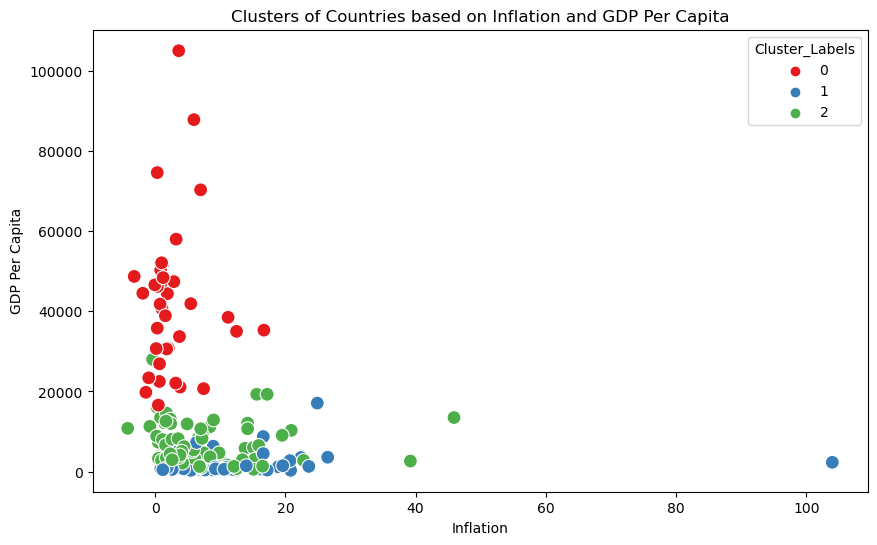

In [232]:
# Visualisation of clusters: inflation vs gdpp

plt.figure(figsize=(10, 6))
sns.scatterplot(x='inflation', y='gdpp', hue='Cluster_Labels', data=df, palette='Set1', s=100)
plt.title('Clusters of Countries based on Inflation and GDP Per Capita')
plt.xlabel('Inflation')
plt.ylabel('GDP Per Capita')
plt.show()


## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

Child mortality ranking highest to lowest

In [233]:
# Sort the data based on child mortality rates in descending order
sorted_data = df.sort_values(by='child_mort', ascending=False)

# Add a new column for ranking
sorted_data['rank_cm'] = range(1, len(sorted_data) + 1)

# Display the ranked data
print(sorted_data[['country', 'child_mort', 'rank_cm']])

                      country  child_mort  rank_cm
66                      Haiti       208.0        1
132              Sierra Leone       160.0        2
32                       Chad       150.0        3
31   Central African Republic       149.0        4
97                       Mali       137.0        5
..                        ...         ...      ...
53                    Finland         3.0      163
144                    Sweden         3.0      164
91                 Luxembourg         2.8      165
133                 Singapore         2.8      166
68                    Iceland         2.6      167

[167 rows x 3 columns]


GDPP rank highest to lowest

In [234]:
# Sort data based on GDP per capita (GDPPP) in descending order
sorted_data = df.sort_values(by='gdpp', ascending=False)

# Add a new column for ranking
sorted_data['rank_gdpp'] = range(1, len(sorted_data) + 1)

# Display the ranked data
print(sorted_data[['country', 'gdpp', 'rank_gdpp']])

              country    gdpp  rank_gdpp
91         Luxembourg  105000          1
114            Norway   87800          2
145       Switzerland   74600          3
123             Qatar   70300          4
44            Denmark   58000          5
..                ...     ...        ...
132      Sierra Leone     399        163
112             Niger     348        164
37   Congo, Dem. Rep.     334        165
88            Liberia     327        166
26            Burundi     231        167

[167 rows x 3 columns]


Inflation highest to lowest

In [235]:
# Sort data based on inflation in descending order
sorted_data = df.sort_values(by='inflation', ascending=False)

# Add a new column for ranking
sorted_data['rank_inf'] = range(1, len(sorted_data) + 1)

# Display the ranked data
print(sorted_data[['country', 'inflation', 'rank_inf']])

               country  inflation  rank_inf
113            Nigeria    104.000         1
163          Venezuela     45.900         2
103           Mongolia     39.200         3
149        Timor-Leste     26.500         4
49   Equatorial Guinea     24.900         5
..                 ...        ...       ...
135           Slovenia     -0.987       163
43      Czech Republic     -1.430       164
77               Japan     -1.900       165
73             Ireland     -3.220       166
131         Seychelles     -4.210       167

[167 rows x 3 columns]
